In [5]:
import yfinance as yf
import pandas as pd

# Define tickers and time period
tickers = ['SPY', 'AAPL']
start_date = '2005-01-01'
end_date = '2025-09-30'

# Download data
data = yf.download(tickers, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    adj_close = data['Close']                  # adjusted closes
else:
    adj_close = data[['Close']].rename(columns={'Close': tickers[0]})


/var/folders/9z/26jz_ql9507379s_bv_2qyq40000gn/T/ipykernel_16800/599149433.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  2 of 2 completed


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

def download_ohlc(tickers, start='2005-01-01', end=None):
    data = yf.download(list(tickers), start=start, end=end, auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        out = {tk: data.xs(tk, axis=1, level=1)[['Open','High','Low','Close']].dropna()
               for tk in tickers}
    else:  # single ticker
        tk = tickers[0] if isinstance(tickers, (list, tuple)) else tickers
        out = {tk: data[['Open','High','Low','Close']].dropna()}
    return out

def tally_trailing_triggers(df, thresholds=(0.05, 0.10, 0.15)):
    c = df['Close']
    roll_max = c.cummax()
    dd = c / roll_max - 1.0  # negative when below the running high

    rows = []
    dates_map = {}
    for t in thresholds:
        crossed = (dd <= -t) & (dd.shift(1) > -t)  # first day it breaches that level
        dates = list(dd.index[crossed])
        rows.append({'Threshold %': int(t*100), '# Triggers': len(dates)})
        dates_map[int(t*100)] = dates
    return pd.DataFrame(rows), dates_map

def tally_fixed_from_entry(df, thresholds=(0.05, 0.10, 0.15)):
    c = df['Close']
    entry = c.iloc[0]
    stops = {int(t*100): entry * (1 - t) for t in thresholds}
    out = []
    dates_map = {}
    for pct, stop_level in stops.items():
        hit = (df['Low'] <= stop_level)
        if hit.any():
            first_date = df.index[hit.values.argmax()]  # first True
            out.append({'Threshold %': pct, '# Triggers': 1})
            dates_map[pct] = [first_date]
        else:
            out.append({'Threshold %': pct, '# Triggers': 0})
            dates_map[pct] = []
    return pd.DataFrame(out), dates_map

def summarize_tallies(tickers=('SPY','AAPL'), start='2010-01-01', mode='trailing'):
    data = download_ohlc(tickers, start=start)
    rows = []
    dates_by_ticker = {}
    for tk, df in data.items():
        if mode == 'trailing':
            tbl, dates = tally_trailing_triggers(df, thresholds=(0.05,0.10,0.15))
        elif mode == 'fixed':
            tbl, dates = tally_fixed_from_entry(df, thresholds=(0.05,0.10,0.15))
        else:
            raise ValueError("mode must be 'trailing' or 'fixed'")
        tbl.insert(0, 'Ticker', tk)
        rows.append(tbl)
        dates_by_ticker[tk] = dates
    summary = pd.concat(rows, ignore_index=True)
    return summary, dates_by_ticker



    

In [7]:
summary_trailing, dates_trailing = summarize_tallies(('SPY','AAPL'), start='2005-01-01', mode='trailing')
print(summary_trailing); dates_trailing['SPY'][5]  # list of dates when 5% trailing stop was triggered

  Ticker  Threshold %  # Triggers
0    SPY            5          77
1    SPY           10          35
2    SPY           15          37
3   AAPL            5         150
4   AAPL           10         103
5   AAPL           15          68


[Timestamp('2005-04-14 00:00:00'),
 Timestamp('2005-04-26 00:00:00'),
 Timestamp('2005-05-12 00:00:00'),
 Timestamp('2005-10-12 00:00:00'),
 Timestamp('2005-10-18 00:00:00'),
 Timestamp('2005-10-20 00:00:00'),
 Timestamp('2006-05-23 00:00:00'),
 Timestamp('2006-06-07 00:00:00'),
 Timestamp('2006-06-16 00:00:00'),
 Timestamp('2006-07-13 00:00:00'),
 Timestamp('2006-07-20 00:00:00'),
 Timestamp('2007-03-02 00:00:00'),
 Timestamp('2007-03-13 00:00:00'),
 Timestamp('2007-07-27 00:00:00'),
 Timestamp('2007-07-31 00:00:00'),
 Timestamp('2007-08-03 00:00:00'),
 Timestamp('2007-08-09 00:00:00'),
 Timestamp('2007-08-27 00:00:00'),
 Timestamp('2007-09-07 00:00:00'),
 Timestamp('2007-11-07 00:00:00'),
 Timestamp('2007-12-03 00:00:00'),
 Timestamp('2007-12-11 00:00:00'),
 Timestamp('2007-12-14 00:00:00'),
 Timestamp('2007-12-27 00:00:00'),
 Timestamp('2012-03-06 00:00:00'),
 Timestamp('2012-05-14 00:00:00'),
 Timestamp('2012-06-21 00:00:00'),
 Timestamp('2012-07-10 00:00:00'),
 Timestamp('2012-07-

,Ticker,CAGR %,Sharpe,Max Drawdown %,Longest Recovery (days)
0,AAPL,30.68,0.99,-60.9,456
1,SPY,10.53,0.62,-55.2,1223


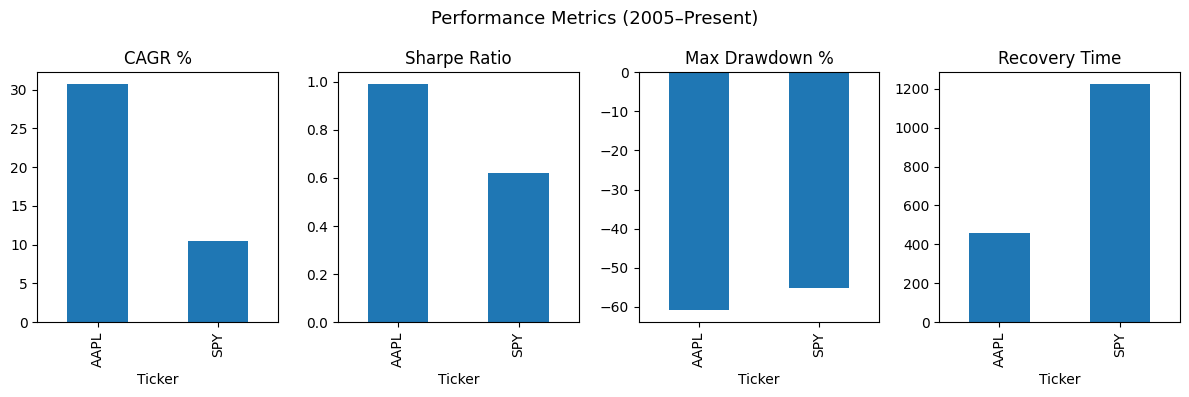

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Download ----------
def get_prices(tickers=('SPY','AAPL'), start='2005-01-01', end=None):
    data = yf.download(list(tickers), start=start, end=end, auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        return data['Close']
    else:
        return data[['Close']]

# ---------- Metric functions ----------
def compute_metrics(prices):
    metrics = []
    for tk in prices.columns:
        p = prices[tk].dropna()
        rets = p.pct_change().dropna()
        # CAGR
        years = (p.index[-1]-p.index[0]).days / 365.25
        cagr = (p.iloc[-1]/p.iloc[0])**(1/years) - 1
        # Sharpe (daily mean/std * sqrt(252))
        sharpe = np.sqrt(252) * rets.mean() / rets.std()
        # Drawdown & Recovery
        roll_max = p.cummax()
        dd = p/roll_max - 1
        max_dd = dd.min()
        # Recovery time = longest streak below prior peak
        below = (p < roll_max)
        longest, cur = 0, 0
        for flag in below:
            if flag: cur += 1; longest = max(longest, cur)
            else: cur = 0
        metrics.append({
            'Ticker': tk,
            'CAGR %': round(100*cagr,2),
            'Sharpe': round(sharpe,2),
            'Max Drawdown %': round(100*max_dd,1),
            'Longest Recovery (days)': longest
        })
    return pd.DataFrame(metrics)

# ---------- Plotting ----------
def plot_metric_bars(df_metrics):
    fig, axes = plt.subplots(1,4, figsize=(12,4))
    df_metrics.plot(x='Ticker', y='CAGR %', kind='bar', ax=axes[0], legend=False, title='CAGR %')
    df_metrics.plot(x='Ticker', y='Sharpe', kind='bar', ax=axes[1], legend=False, title='Sharpe Ratio')
    df_metrics.plot(x='Ticker', y='Max Drawdown %', kind='bar', ax=axes[2], legend=False, title='Max Drawdown %')
    df_metrics.plot(x='Ticker', y='Longest Recovery (days)', kind='bar', ax=axes[3], legend=False, title='Recovery Time')
    plt.suptitle('Performance Metrics (2005–Present)', fontsize=13)
    plt.tight_layout()
    plt.show()

# ---------- Run ----------
prices = get_prices(('SPY','AAPL'), start='2005-01-01')
metrics_df = compute_metrics(prices)
display(metrics_df)
plot_metric_bars(metrics_df)



STOP-LOSS STRATEGY ANALYZER
Quantitative Analysis of Fixed Stop-Loss Levels


ANALYZING AAPL

Fetching AAPL data from 2020-10-14 to 2025-10-13...


/var/folders/9z/26jz_ql9507379s_bv_2qyq40000gn/T/ipykernel_12232/848143653.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date, progress=False)


Simulating 5% stop-loss strategy...
Simulating 10% stop-loss strategy...
Simulating 15% stop-loss strategy...
Simulating Buy & Hold strategy...

RESULTS FOR AAPL

  Strategy Final Value Total Return  Stop-Loss Triggers Win Rate Max Drawdown Avg Recovery (days)  Num Trades
        5%     $20,822       108.2%                   2    33.3%        33.4%                 190           3
       10%     $20,823       108.2%                   1    50.0%        33.4%                 190           2
       15%     $20,806       108.1%                   0   100.0%        33.4%                 190           1
Buy & Hold     $20,806       108.1%                   0   100.0%        33.4%                 190           1

Visualization saved as 'AAPL_stop_loss_analysis.png'


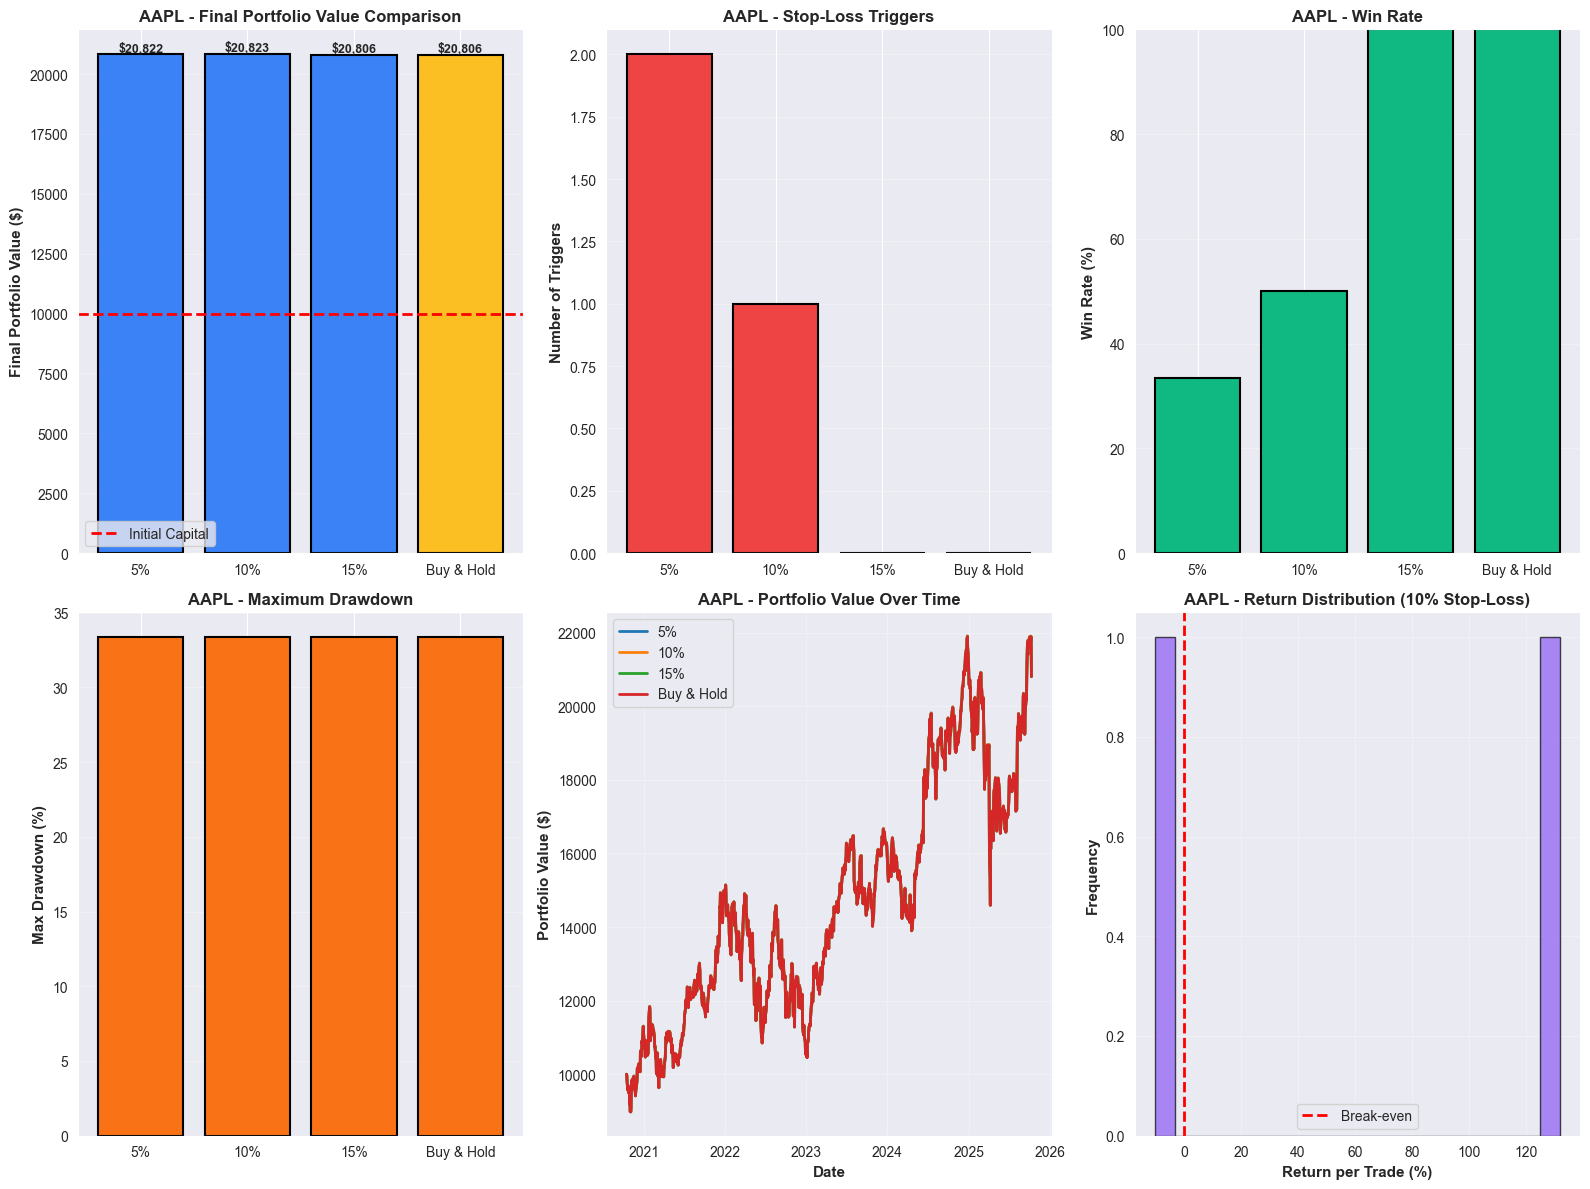


ANALYZING SPY

Fetching SPY data from 2020-10-14 to 2025-10-13...


/var/folders/9z/26jz_ql9507379s_bv_2qyq40000gn/T/ipykernel_12232/848143653.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date, progress=False)


Simulating 5% stop-loss strategy...
Simulating 10% stop-loss strategy...
Simulating 15% stop-loss strategy...
Simulating Buy & Hold strategy...

RESULTS FOR SPY

  Strategy Final Value Total Return  Stop-Loss Triggers Win Rate Max Drawdown Avg Recovery (days)  Num Trades
        5%     $19,930        99.3%                   1    50.0%        24.5%                 358           2
       10%     $20,132       101.3%                   0   100.0%        24.5%                 356           1
       15%     $20,132       101.3%                   0   100.0%        24.5%                 356           1
Buy & Hold     $20,132       101.3%                   0   100.0%        24.5%                 356           1

Visualization saved as 'SPY_stop_loss_analysis.png'


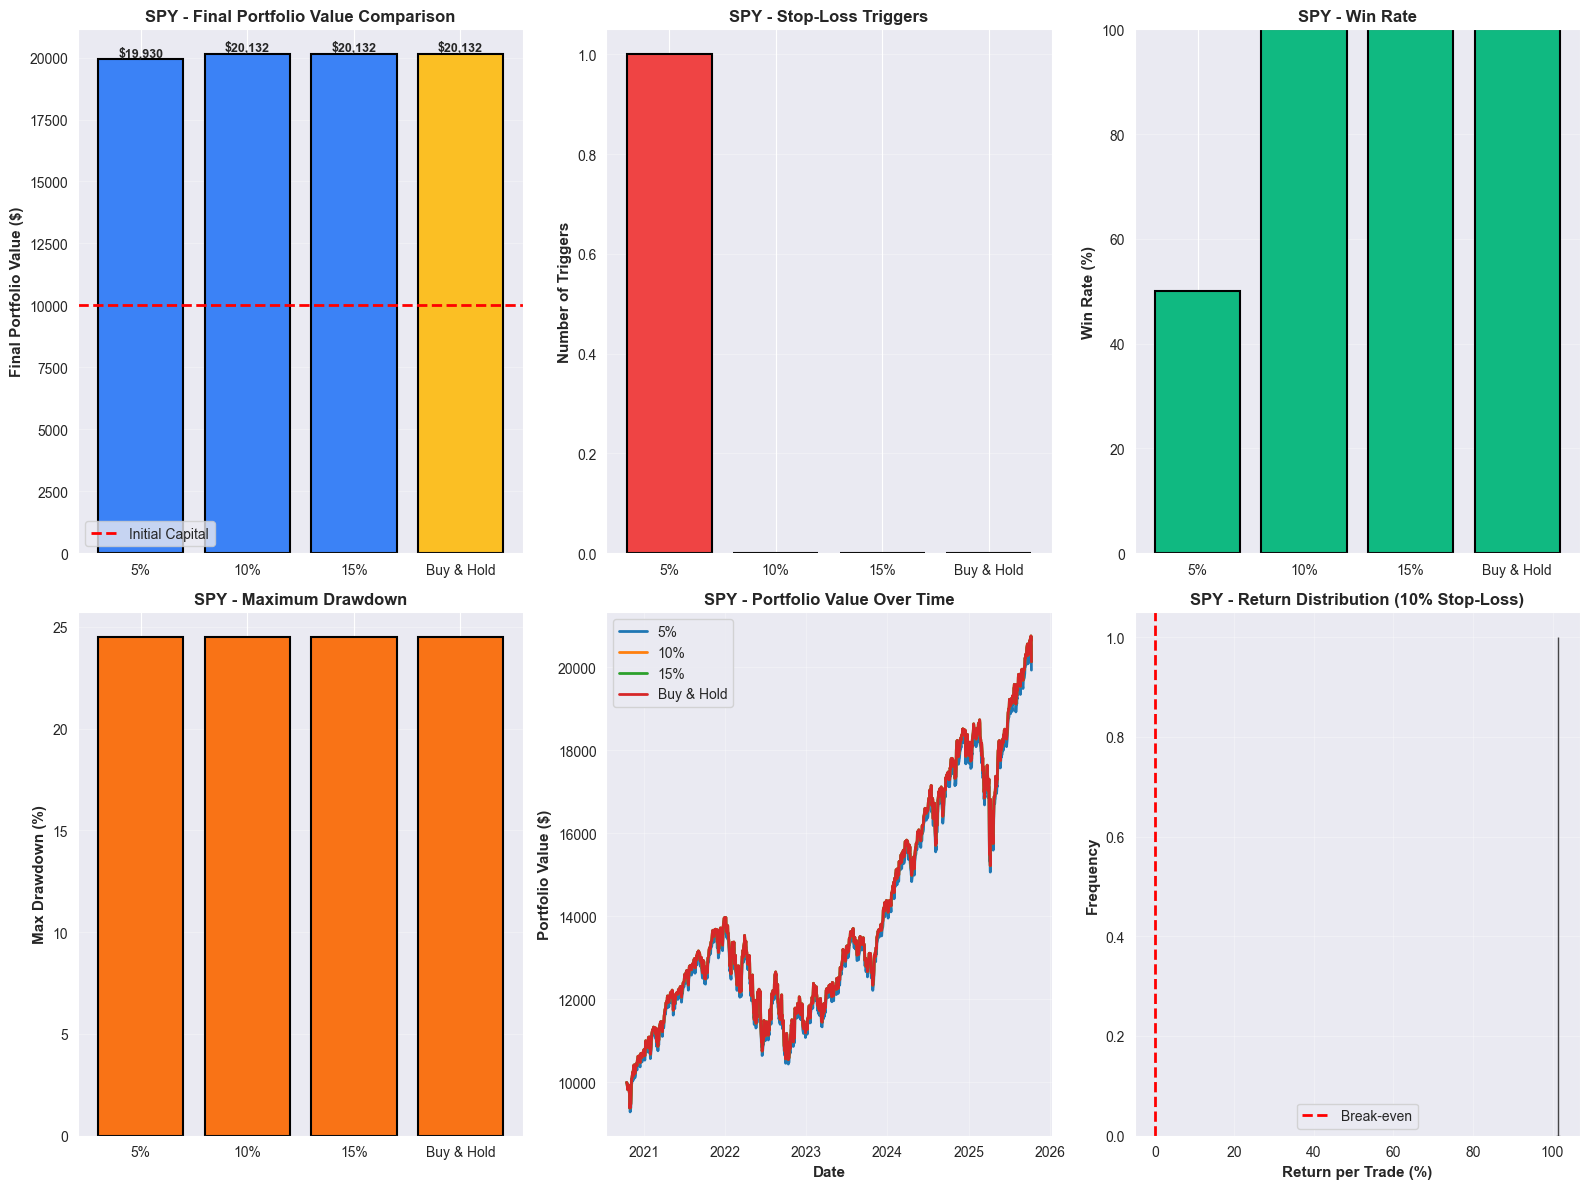


CROSS-ASSET COMPARISON


5% Strategy:
  AAPL: Final Value = $20,822 | Return = 108.2% | Max DD = 33.4% | Win Rate = 33.3%
  SPY: Final Value = $19,930 | Return = 99.3% | Max DD = 24.5% | Win Rate = 50.0%

10% Strategy:
  AAPL: Final Value = $20,823 | Return = 108.2% | Max DD = 33.4% | Win Rate = 50.0%
  SPY: Final Value = $20,132 | Return = 101.3% | Max DD = 24.5% | Win Rate = 100.0%

15% Strategy:
  AAPL: Final Value = $20,806 | Return = 108.1% | Max DD = 33.4% | Win Rate = 100.0%
  SPY: Final Value = $20,132 | Return = 101.3% | Max DD = 24.5% | Win Rate = 100.0%

Buy & Hold Strategy:
  AAPL: Final Value = $20,806 | Return = 108.1% | Max DD = 33.4% | Win Rate = 100.0%
  SPY: Final Value = $20,132 | Return = 101.3% | Max DD = 24.5% | Win Rate = 100.0%

Analysis complete! Check the generated PNG files for visualizations.



In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set style for better-looking plots
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

def fetch_stock_data(ticker, years=5):
    """Fetch historical stock data from Yahoo Finance"""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*years)
    
    print(f"Fetching {ticker} data from {start_date.date()} to {end_date.date()}...")
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Extract Adj Close - yfinance returns it directly as a column
    if 'Adj Close' in stock.columns:
        adj_close = stock['Adj Close']
    else:
        # Fallback to Close if Adj Close not available
        adj_close = stock['Close']
    
    # Ensure it's a Series with datetime index
    if isinstance(adj_close, pd.DataFrame):
        adj_close = adj_close.iloc[:, 0]
    
    return adj_close.dropna()

def simulate_stop_loss(prices, stop_loss_pct, initial_capital=10000):
    """
    Simulate a stop-loss strategy on historical price data
    
    Parameters:
    - prices: Series of adjusted closing prices
    - stop_loss_pct: Stop-loss threshold as percentage (e.g., 5 for 5%)
    - initial_capital: Starting capital in dollars
    
    Returns:
    - Dictionary with performance metrics
    """
    position = None  # Entry price
    cash = initial_capital
    shares = 0
    peak_value = initial_capital
    max_drawdown = 0
    stop_loss_triggers = 0
    trades = []
    portfolio_values = []
    drawdown_periods = []
    current_drawdown_start = None
    
    for i in range(len(prices)):
        date = prices.index[i]
        price = float(prices.iloc[i])
        
        if position is None:
            # Enter position (buy)
            position = price
            shares = cash / price
            cash = 0
            trades.append({
                'date': date,
                'type': 'BUY',
                'price': price,
                'shares': shares,
                'value': shares * price
            })
        else:
            # Calculate current portfolio value and drawdown from entry
            current_value = shares * price
            drawdown_from_entry = (position - price) / position
            
            # Track peak value and overall drawdown
            if current_value > peak_value:
                if current_drawdown_start is not None:
                    # Recovery achieved
                    recovery_days = (date - current_drawdown_start).days
                    drawdown_periods.append(recovery_days)
                    current_drawdown_start = None
                peak_value = current_value
            
            # Calculate drawdown from peak
            current_drawdown = (peak_value - current_value) / peak_value
            if current_drawdown > max_drawdown:
                max_drawdown = current_drawdown
                if current_drawdown_start is None:
                    current_drawdown_start = date
            
            # Check if stop-loss is triggered
            if drawdown_from_entry >= stop_loss_pct / 100:
                # Exit position (sell)
                cash = shares * price
                profit = cash - (shares * position)
                trades.append({
                    'date': date,
                    'type': 'SELL',
                    'price': price,
                    'shares': shares,
                    'value': cash,
                    'profit': profit,
                    'return_pct': (profit / (shares * position)) * 100
                })
                shares = 0
                position = None
                stop_loss_triggers += 1
        
        # Record portfolio value
        portfolio_value = cash if position is None else shares * price
        portfolio_values.append({
            'date': date,
            'value': portfolio_value
        })
    
    # Close final position if still open
    if position is not None:
        final_date = prices.index[-1]
        final_price = float(prices.iloc[-1])
        cash = shares * final_price
        profit = cash - (shares * position)
        trades.append({
            'date': final_date,
            'type': 'SELL',
            'price': final_price,
            'shares': shares,
            'value': cash,
            'profit': profit,
            'return_pct': (profit / (shares * position)) * 100
        })
    
    # Calculate metrics
    sell_trades = [t for t in trades if t['type'] == 'SELL']
    profitable_trades = [t for t in sell_trades if t.get('profit', 0) > 0]
    win_rate = len(profitable_trades) / len(sell_trades) if sell_trades else 0
    avg_recovery_days = np.mean(drawdown_periods) if drawdown_periods else None
    
    final_value = cash
    total_return = (final_value - initial_capital) / initial_capital
    
    return {
        'final_value': final_value,
        'total_return': total_return,
        'stop_loss_triggers': stop_loss_triggers,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'avg_recovery_days': avg_recovery_days,
        'num_trades': len(sell_trades),
        'trades': trades,
        'portfolio_values': pd.DataFrame(portfolio_values)
    }

def run_analysis(ticker, stop_loss_levels=[5, 10, 15]):
    """Run stop-loss analysis for a given ticker"""
    print(f"\n{'='*60}")
    print(f"ANALYZING {ticker}")
    print(f"{'='*60}\n")
    
    # Fetch data
    prices = fetch_stock_data(ticker)
    
    # Run simulations
    results = {}
    for level in stop_loss_levels:
        print(f"Simulating {level}% stop-loss strategy...")
        results[f"{level}%"] = simulate_stop_loss(prices, level)
    
    # Add buy-and-hold baseline
    print(f"Simulating Buy & Hold strategy...")
    results["Buy & Hold"] = simulate_stop_loss(prices, 100)  # 100% means no stop-loss
    
    return results, prices

def print_results(ticker, results):
    """Print formatted results table"""
    print(f"\n{'='*80}")
    print(f"RESULTS FOR {ticker}")
    print(f"{'='*80}\n")
    
    # Create results table
    data = []
    for strategy, metrics in results.items():
        data.append({
            'Strategy': strategy,
            'Final Value': f"${metrics['final_value']:,.0f}",
            'Total Return': f"{metrics['total_return']*100:.1f}%",
            'Stop-Loss Triggers': metrics['stop_loss_triggers'],
            'Win Rate': f"{metrics['win_rate']*100:.1f}%",
            'Max Drawdown': f"{metrics['max_drawdown']*100:.1f}%",
            'Avg Recovery (days)': f"{metrics['avg_recovery_days']:.0f}" if metrics['avg_recovery_days'] else "N/A",
            'Num Trades': metrics['num_trades']
        })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    print()

def create_visualizations(ticker, results, prices):
    """Create comprehensive visualizations"""
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Performance Comparison (Bar Chart)
    ax1 = plt.subplot(2, 3, 1)
    strategies = list(results.keys())
    final_values = [results[s]['final_value'] for s in strategies]
    colors = ['#3b82f6', '#3b82f6', '#3b82f6', '#fbbf24']
    bars = ax1.bar(strategies, final_values, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Final Portfolio Value ($)', fontsize=11, fontweight='bold')
    ax1.set_title(f'{ticker} - Final Portfolio Value Comparison', fontsize=12, fontweight='bold')
    ax1.axhline(y=10000, color='red', linestyle='--', label='Initial Capital', linewidth=2)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 2. Stop-Loss Triggers
    ax2 = plt.subplot(2, 3, 2)
    triggers = [results[s]['stop_loss_triggers'] for s in strategies]
    ax2.bar(strategies, triggers, color='#ef4444', edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Number of Triggers', fontsize=11, fontweight='bold')
    ax2.set_title(f'{ticker} - Stop-Loss Triggers', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Win Rate
    ax3 = plt.subplot(2, 3, 3)
    win_rates = [results[s]['win_rate'] * 100 for s in strategies]
    ax3.bar(strategies, win_rates, color='#10b981', edgecolor='black', linewidth=1.5)
    ax3.set_ylabel('Win Rate (%)', fontsize=11, fontweight='bold')
    ax3.set_title(f'{ticker} - Win Rate', fontsize=12, fontweight='bold')
    ax3.set_ylim([0, 100])
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Max Drawdown
    ax4 = plt.subplot(2, 3, 4)
    drawdowns = [results[s]['max_drawdown'] * 100 for s in strategies]
    ax4.bar(strategies, drawdowns, color='#f97316', edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Max Drawdown (%)', fontsize=11, fontweight='bold')
    ax4.set_title(f'{ticker} - Maximum Drawdown', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Portfolio Value Over Time
    ax5 = plt.subplot(2, 3, 5)
    for strategy in strategies:
        pv = results[strategy]['portfolio_values']
        ax5.plot(pv['date'], pv['value'], label=strategy, linewidth=2)
    ax5.set_ylabel('Portfolio Value ($)', fontsize=11, fontweight='bold')
    ax5.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax5.set_title(f'{ticker} - Portfolio Value Over Time', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # 6. Return Distribution (for 10% stop-loss)
    ax6 = plt.subplot(2, 3, 6)
    trades_10 = [t for t in results['10%']['trades'] if t['type'] == 'SELL' and 'return_pct' in t]
    if trades_10:
        returns = [t['return_pct'] for t in trades_10]
        ax6.hist(returns, bins=20, color='#8b5cf6', edgecolor='black', alpha=0.7)
        ax6.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
        ax6.set_xlabel('Return per Trade (%)', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax6.set_title(f'{ticker} - Return Distribution (10% Stop-Loss)', fontsize=12, fontweight='bold')
        ax6.legend()
        ax6.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{ticker}_stop_loss_analysis.png', dpi=300, bbox_inches='tight')
    print(f"Visualization saved as '{ticker}_stop_loss_analysis.png'")
    plt.show()

def main():
    """Main execution function"""
    print("\n" + "="*80)
    print("STOP-LOSS STRATEGY ANALYZER")
    print("Quantitative Analysis of Fixed Stop-Loss Levels")
    print("="*80 + "\n")
    
    tickers = ['AAPL', 'SPY']
    stop_loss_levels = [5, 10, 15]
    
    all_results = {}
    
    for ticker in tickers:
        results, prices = run_analysis(ticker, stop_loss_levels)
        all_results[ticker] = results
        print_results(ticker, results)
        create_visualizations(ticker, results, prices)
    
    # Summary comparison
    print("\n" + "="*80)
    print("CROSS-ASSET COMPARISON")
    print("="*80 + "\n")
    
    for strategy in ['5%', '10%', '15%', 'Buy & Hold']:
        print(f"\n{strategy} Strategy:")
        for ticker in tickers:
            metrics = all_results[ticker][strategy]
            print(f"  {ticker}: Final Value = ${metrics['final_value']:,.0f} | "
                  f"Return = {metrics['total_return']*100:.1f}% | "
                  f"Max DD = {metrics['max_drawdown']*100:.1f}% | "
                  f"Win Rate = {metrics['win_rate']*100:.1f}%")
    
    print("\n" + "="*80)
    print("Analysis complete! Check the generated PNG files for visualizations.")
    print("="*80 + "\n")

if __name__ == "__main__":
    main()